# Annotation

# Agenda

1. Outlier Detection
    1. Point Outliers
    1. Subsequence outliers with skchange
1. Change point detection
    1. Evaluating Change Point Detection Models

# The Annotation Module

The annotaion module is an experimental module that is still under heavy development. It includes several scattered algorithms that we are working to unify.

<img src="img/annotation_tree.png" width="800">

# Use Cases

**Outlier Detection**

1. Removing unrealistic data points.
1. Finding points or areas of interest.

**Change Point Detection**

1. Detecting detecting signifant changes is how your data is generated.

**Segmentation**

1. Finding sequences of anomalous points.
2. Finding common patterns or motifs in your dataset.

# Types of Outliers

1. Point outliers: Individual data point that unusual compared to the whole timeseries (global) or a neighbouring points (local).
1. Subsequence outliers: Sequence of inidividual points that are unusual when compared to others.
1. Finding anomalous timeseries.

In [3]:
import os
import pathlib
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Detecting Point Outliers

A data point is a point outlier if it is extremely high or extremely low compared to the rest of the timeseries. We will train a model to detect point outliers on the Yahoo dataset.

The Yahoo timeseries dataset contains synthetic labelled anomalies. In reality, outlier detection is usually an unsupervised learning task so the labels are not provided.

In [4]:
data_root = pathlib.Path("../data")
df = pd.read_csv(data_root / "yahoo.csv")
df.head()

,data,label
0,-46.394356,0
1,311.346234,0
2,543.279051,0
3,603.441983,0
4,652.807243,0


Plot the timeseries.

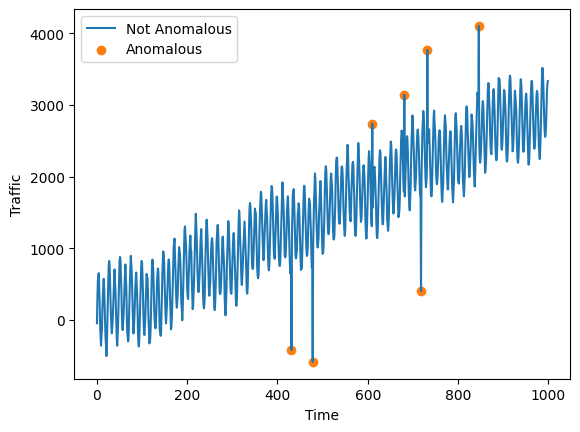

In [5]:
fig, ax = plt.subplots()
ax.plot(df["data"], label="Not Anomalous")

mask = df["label"] == 1.0
ax.scatter(df.loc[mask].index, df.loc[mask, "data"], label="Anomalous", color="tab:orange")

ax.legend()
ax.set_ylabel("Traffic")
ax.set_xlabel("Time")
fig.savefig("outlier_example.png")

Sktime provides several agorithms for anomaly detection. STRAY is one such algorithm.

In [6]:
from sktime.annotation.stray import STRAY

model = STRAY()
model.fit(df["data"])
y_hat = model.transform(df["data"])  # True if anomalous, false otherwise
y_hat

0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: data, Length: 1000, dtype: bool

Use `sum` to find the number of anomalies that have been detected.

In [7]:
y_hat.sum()

3

Plot the predicted anomalies.

Text(0.5, 1.0, 'Predicted Anomalies')

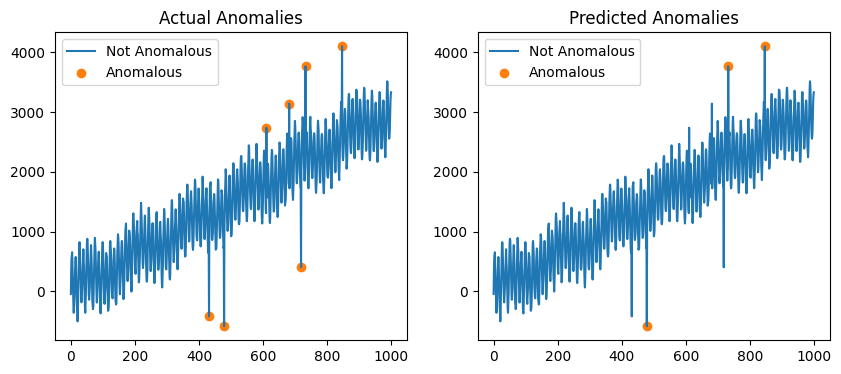

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the actual anomalies in the first figure
mask = df["label"] == 1.0
ax[0].plot(df["data"], label="Not Anomalous")
ax[0].scatter(df.loc[mask].index, df.loc[mask, "data"], color="tab:orange", label="Anomalous")
ax[0].legend()
ax[0].set_title("Actual Anomalies")

# Plot the predicted anomalies in the second figure
ax[1].plot(df["data"], label="Not Anomalous")
ax[1].scatter(df.loc[y_hat].index, df.loc[y_hat, "data"], color="tab:orange", label="Anomalous" )
ax[1].legend()
ax[1].set_title("Predicted Anomalies")

STRAY is a modified version of the KNN algorithm. It cannot handle the trend in the dataset so the maximum and minimum values are flagged as anomalous.

Sktime provides methods for removing trend that can be used with STRAY.

Text(0.5, 1.0, 'Actual Anomalies')

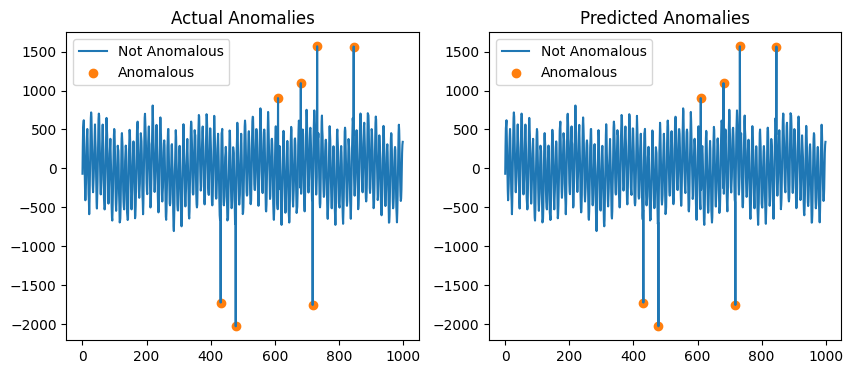

In [9]:
from sktime.transformations.series.detrend import Detrender

X_detrended = Detrender().fit_transform(df["data"])

model = STRAY()
model.fit(X_detrended)
y_hat = model.transform(X_detrended)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1].plot(X_detrended, label="Not Anomalous")
ax[1].scatter(X_detrended.loc[y_hat].index, X_detrended.loc[y_hat], color="tab:orange", label="Anomalous")
ax[1].legend()
ax[1].set_title("Predicted Anomalies")

ax[0].plot(X_detrended, label="Not Anomalous")
ax[0].scatter(X_detrended.loc[df["label"] == 1.0].index, X_detrended.loc[df["label"] == 1.0], color="tab:orange", label="Anomalous")
ax[0].legend()
ax[0].set_title("Actual Anomalies")

## Detecting Subsequence Outliers

Subsequence outliers are groups of consecutive points whose behaviour is unusual. The `mitdb.csv` dataset has an example of a subsequence outlier. This timeseries is an ECG recording.

In [12]:
path = pathlib.Path(data_root / "mitdb.csv")
df = pd.read_csv(path)
df.head()

,data,label
0,-0.195,0
1,-0.210,0
2,-0.210,0
3,-0.225,0
4,-0.220,0


Plot the timeseries.

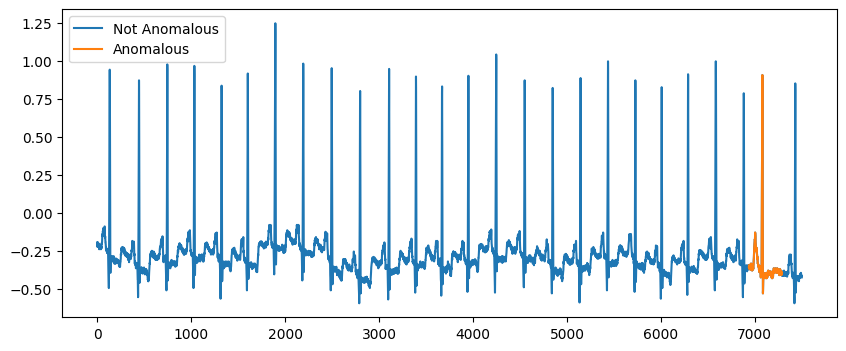

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(df["data"], label="Not Anomalous")
ax.plot(df.loc[df["label"] == 1.0, "data"], label="Anomalous")
ax.legend()

Use Capa from `skchange` to predict the anomalous subsequence. https://github.com/NorskRegnesentral/skchange.

In [15]:
from skchange.anomaly_detectors.capa import Capa

model = Capa(max_segment_length=350)
model.fit(df["data"])
anomaly_intervals = model.predict(df["data"])
anomaly_intervals

0    [7084, 7425]
Name: anomaly_interval, dtype: interval

In [41]:
print("left: ", anomaly_intervals.iat[0].left)
print("right: ", anomaly_intervals.iat[0].right)

left:  7084
right:  7425


Capa returns the anomalous subsequences as a series of intervals.

Plot the anomalous subsequence.

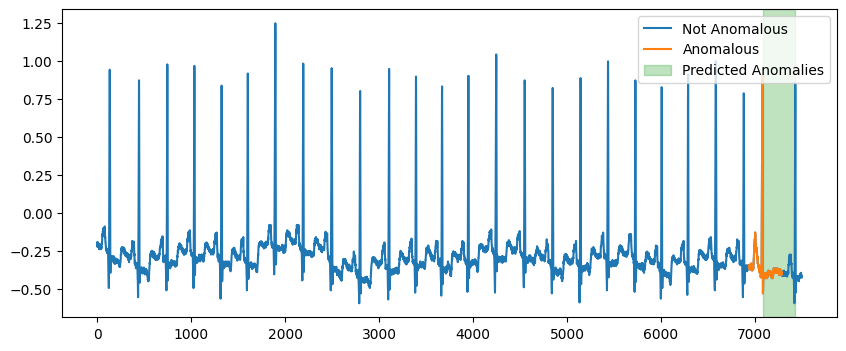

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["data"], label="Not Anomalous")
ax.plot(df.loc[df["label"] == 1.0, "data"], label="Anomalous")

for interval in anomaly_intervals:
    left = interval.left
    right = interval.right
    ax.axvspan(left, right, color="tab:green", alpha=0.3, label="Predicted Anomalies")

ax.legend()

## Change Point Detection

Change point detection is used to find points in a timeseries where the underlying mechanism generating the data changes. 

As an example, we explore the *seatbelt* dataset.

In [17]:
df = pd.read_csv(data_root / "seatbelts.csv", index_col=0, parse_dates=True)
df.head()

,KSI,label
1969-01-01,1687,0
1969-02-01,1508,0
1969-03-01,1507,0
1969-04-01,1385,0
1969-05-01,1632,0


Plot the seatbelt dataset.

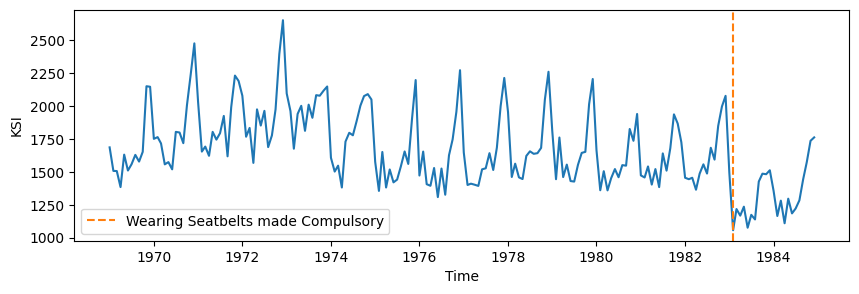

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(df["KSI"])

actual_cp = datetime.datetime(1983, 2, 1)
ax.axvline(actual_cp, color="tab:orange", linestyle="--", label="Wearing Seatbelts made Compulsory")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("KSI")
fig.savefig("seatbelt_example.png")

* It was made compulsory to wear a seatbelt in the UK on January 31st 1983.
* It was made mandatory to install seatbelts in all new cars in 1968.

Use binary segmentation to find a drop in 1000 KSI change point.

In [19]:
from sktime.annotation.bs import BinarySegmentation

model = BinarySegmentation(threshold=1000)
predicted_change_points = model.fit_predict(df)
print(predicted_change_points)

0   1974-12-01
1   1983-01-01
dtype: datetime64[ns]


For change point detectors, `predict` returns a series containing the indexes of the change points.

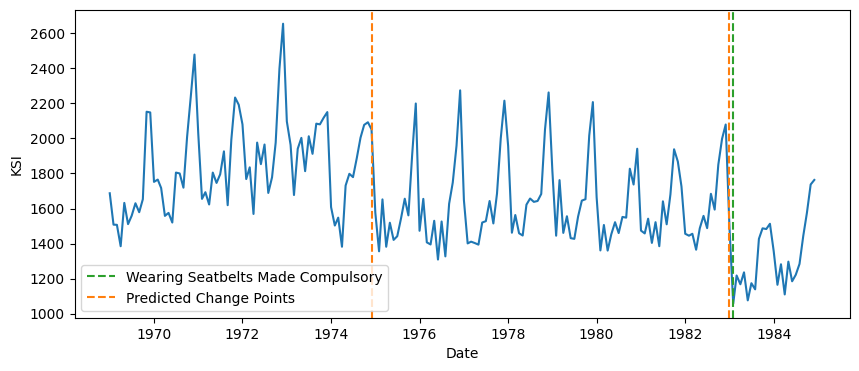

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["KSI"])
ax.axvline(actual_cp, label="Wearing Seatbelts Made Compulsory", color="tab:green", linestyle="--")

for i, cp in enumerate(predicted_change_points):
    label = "Predicted Change Points" if i == 0 else None
    ax.axvline(cp, color="tab:orange", linestyle="--", label=label)

ax.set_ylabel("KSI")
ax.set_xlabel("Date")
ax.legend()

The change point was identified almost exactly.

## Change Point Scoring Metrics

* Change detection can be evaluated like a classification problem i.e. how often does the the model correctly identify change points and not change points.
* Usually change points are very rare meaning your accuracy is going to biased.
* We could use F1 score instead which does not use true negatives.

<img src="img/f1_score.png" width=700 />

To calculate the F1 for our predictions using scikit-learn, we first need to get our predictions in dense format.

In [20]:
y_hat = model.predict(df["KSI"])
y_hat

0   1974-12-01
1   1983-01-01
dtype: datetime64[ns]

In [22]:
y_hat_dense = model.sparse_to_dense(y_hat, df.index)
y_hat_dense

1969-01-01    0
1969-02-01    0
1969-03-01    0
1969-04-01    0
1969-05-01    0
             ..
1984-08-01    0
1984-09-01    0
1984-10-01    0
1984-11-01    0
1984-12-01    0
Length: 192, dtype: int64

Calculate F1 score.

In [23]:
from sklearn.metrics import f1_score

f1_score = f1_score(df["label"], y_hat_dense)
print(f1_score)

0.0


The F1 score is zero even though our model got quite close to the change point. What we need is a metric that is more foregiving of predictions change points that are very close to the actual change points.

Sktime provides a metric called `padded_f1` which pads the true change points so that if the predicted change point is in the correct range, the prediction is considered to be correct.

In [24]:
def padded_f1(true_change_points, pred_change_points, pad):
    """Calculate padded F1 score for change point detection.

    Parameters
    ----------
    true_change_points: pd.Series
        True change point positions. Can be integers, floats or datetimes.
    precicted_change_points: pd.Series
        Precicted change point positions. Can be integers, floats or datetimes.
    pad: int, float, timdelta
        Used to pad the true change points. If a predicted change point falls within
        the range of the padded change then then change point has been correctly
        identified.

    Returns
    -------
    float
        Padded f1 score

    References
    ----------
    .. [1] Gerrit J. J. van den Burg and Christopher K. I. Williams, An Evaluation of
           Change Point Detection Algorithms, 2022, https://arxiv.org/abs/2003.06222
    """
    true_change_points = pd.Series(true_change_points)
    pred_change_points = pd.Series(pred_change_points)

    boundary_left = true_change_points - pad
    boundary_right = true_change_points + pad
    true_cp_intervals = pd.IntervalIndex.from_arrays(boundary_left, boundary_right)

    false_positives = 0
    tp_and_fn = pd.Series(False, index=true_cp_intervals)

    for cp in pred_change_points:
        boolean_mask = tp_and_fn.index.contains(cp)
        if not boolean_mask.any():
            false_positives += 1
        else:
            tp_and_fn = tp_and_fn | boolean_mask

    true_positives = tp_and_fn.sum()
    false_negatives = (~tp_and_fn).sum()

    # Avoid division by zero to mimic sklearn behaviour
    denom = 2 * true_positives + false_positives + false_negatives
    if denom == 0:
        return 0.0

    padded_f1 = 2 * true_positives / denom
    return padded_f1

In [25]:
pad = pd.DateOffset(months=2)
score = padded_f1([actual_cp], model.predict(df["KSI"]), pad=pad)
print(score)

0.6666666666666666


Altering the model to predict more change points will decrease the padded F1 score.

In [26]:
model = BinarySegmentation(threshold=450)
model.fit(df["KSI"])
predicted_change_points = model.predict(df["KSI"])
predicted_change_points

0   1969-10-01
1   1974-12-01
2   1982-09-01
3   1983-01-01
4   1984-09-01
dtype: datetime64[ns]

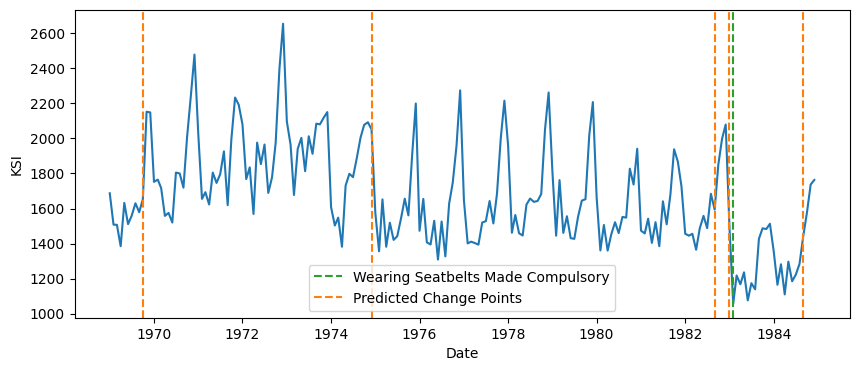

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["KSI"])
ax.axvline(actual_cp, label="Wearing Seatbelts Made Compulsory", color="tab:green", linestyle="--")

for i, cp in enumerate(predicted_change_points):
    label = "Predicted Change Points" if i == 0 else None
    ax.axvline(cp, color="tab:orange", linestyle="--", label=label)

ax.set_ylabel("KSI")
ax.set_xlabel("Date")
ax.legend()

Find the padded F1 score.

In [54]:
pad = pd.DateOffset(months=2)
score = padded_f1([actual_cp], model.predict(df["KSI"]), pad=pad)
print(score)

0.3333333333333333


## Further Reading

* A Review on Outlier/Anomaly Detection in Time Series Data https://arxiv.org/pdf/2002.04236
* A review of change point detection algorithms https://arxiv.org/abs/2003.06222
* A discussion on the limitations of metrics for timeseries anomaly detection https://arxiv.org/pdf/2009.13807.

## Data Sources

* https://github.com/TheDatumOrg/TSB-UAD
* https://github.com/alan-turing-institute/TCPD